In [1]:
import pathlib
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt


import SessionTools.two_photon as st2p


%load_ext autoreload
%autoreload 2 

%matplotlib inline

In [2]:
session_info = {'date': "15_01_2024",
                'genotype_dir': 'ER4d_sytjGCaMP7f_attp2',
                'fly': 'fly2',
                'session': 'closed_loop-000',
                'full_genotype': '+/w-; +/ER4d-AD; UAS-sytjGCaMP7f^{attp2}/ER4d-DBD (SS00238)',
                'ecl date': '' }

bruker_folder = pathlib.PurePath('/media/mplitt/SSD_storage/2PData')
fictrac_folder = pathlib.PurePath('/media/mplitt/SSD_storage/fictrac_folder')
                            

pp = st2p.preprocessing.EBImagingSession(session_info = session_info, 
                                         bruker_base_dir = bruker_folder,
                                         fictrac_base_dir = fictrac_folder)



In [3]:
pp.extract_metadata()
pp.bruker_to_h5(first_chan=2, overwrite=False)
data_corr, shifts, error, diffphase= pp.motion_correct(pp.data)
pp.align_voltage_recording()
nap = pp.open_napari()

(214, 276)
[########################################] | 100% Completed | 27.00 s


In [4]:
print(pp.h5path_raw)

/media/mplitt/SSD_storage/2P_scratch/ER4d_sytjGCaMP7f_attp2/15_01_2024/fly1/dark-003/data.h5


In [5]:
n_rois = 16
nap.make_phase_masks(n_rois=n_rois)
pp.get_layers(nap)
pp.extract_timeseries(max_proj=False)

In [6]:
y = pp.calculate_zscored_F('rois')

In [7]:
pp.save()

In [8]:
pp.timeseries.keys()

dict_keys(['inner_ring', 'outer_ring', 'background', 'rois', 'rois_z'])

In [9]:
y_sm = sp.ndimage.gaussian_filter1d(y, 2, axis=-1)

In [10]:
x_f,y_f = st2p.utilities.pol2cart(-y_sm[0,:,:],np.linspace(-np.pi,np.pi,num=n_rois)[:,np.newaxis])
rho,phi = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0))
print(rho.shape, phi.shape)

heading = pp.voltage_recording_aligned[' Heading'].to_numpy()


(2836,) (2836,)


In [11]:
# Calculate cross-correlation using numpy.correlate
cross_correlation = np.correlate(heading, phi, mode='full')

# Find the index of the maximum correlation
# Define the maximum allowed time lag (adjust as needed)
max_allowed_lag = 10

# Find the index within the specified time lag range that corresponds to the maximum correlation
valid_indices = np.arange(len(cross_correlation))[(len(heading)-1-max_allowed_lag <= np.arange(len(cross_correlation))) & (np.arange(len(cross_correlation)) <= len(heading)-1+max_allowed_lag)]
max_correlation_index = valid_indices[np.argmax(cross_correlation[valid_indices])]

# Calculate the time lag
timelag = max_correlation_index - (len(heading) - 1)

print(timelag)

print(np.corrcoef(heading[:-timelag], phi[timelag:]))
print(np.corrcoef(heading[timelag:], phi[:-timelag]))



-1
[[nan nan]
 [nan nan]]
[[nan nan]
 [nan nan]]


In [12]:
print(heading)

[-1.77181101 -2.24258296 -2.77900561 ...  1.61595979  1.79705849
  1.93868572]


(array([288., 304., 295., 217., 266., 361., 345., 300., 210., 250.]),
 array([-3.13446545, -2.50687236, -1.87927926, -1.25168616, -0.62409306,
         0.00350003,  0.63109313,  1.25868623,  1.88627932,  2.51387242,
         3.14146552]),
 <BarContainer object of 10 artists>)

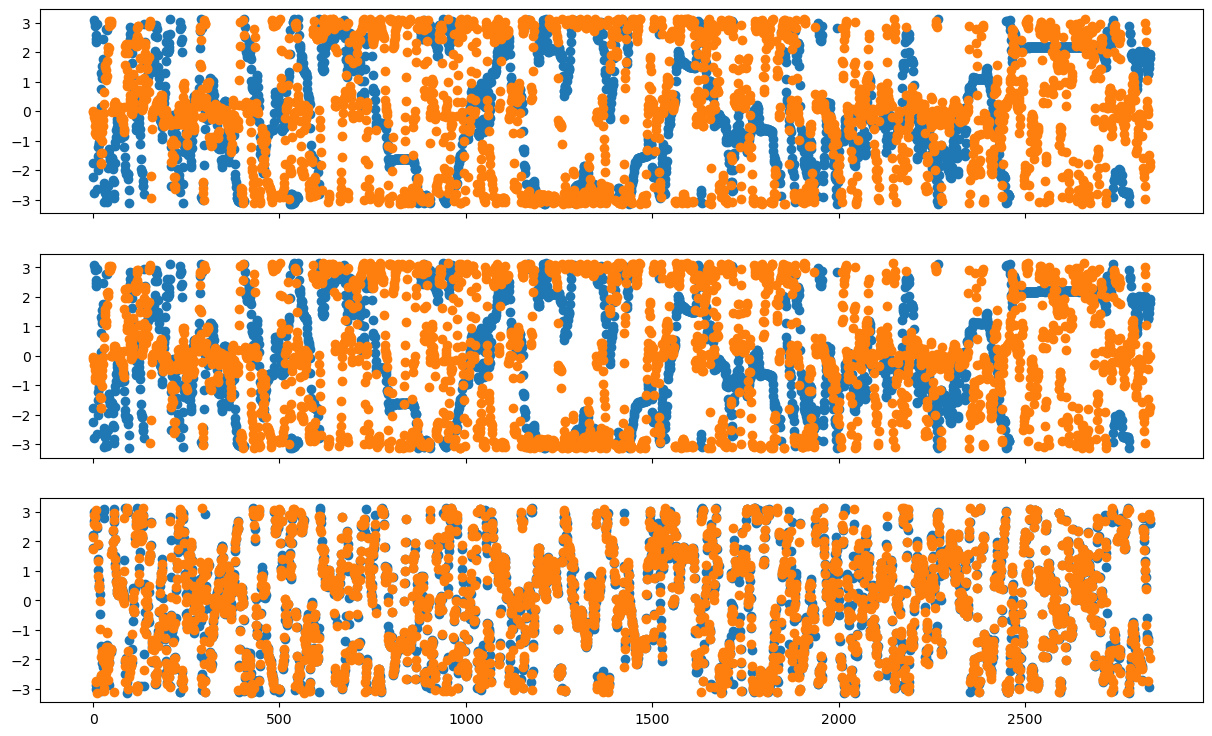

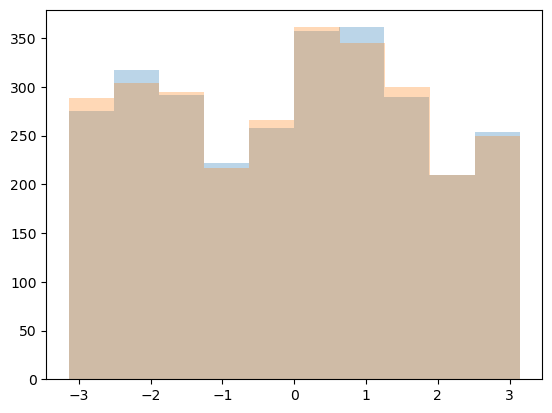

In [13]:
fig, ax= plt.subplots(3,1, figsize=[15,9], sharex=True)
x = np.arange(heading.shape[0])
ax[0].scatter(x,heading)
ax[0].scatter(x, phi)

# x = np.arange(heading.shape[0]-np.abs(timelag))
ax[1].scatter(x,heading)
ax[1].scatter(x, np.roll(phi, timelag))

_,offset = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi-heading))
ax[2].scatter(x,offset)
_,offset2 = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),np.roll(phi,timelag)-heading))
ax[2].scatter(x,offset2)

fig, ax = plt.subplots()
ax.hist(offset, alpha=.3)
ax.hist(offset2, alpha=.3)

Index(['Time(ms)', ' Start Trigger', ' Opto Trigger', ' FicTrac Cam Exp.',
       ' FicTrac Frame Proc.', ' Heading', ' Y/Index', ' Arena DAC1',
       ' Arena DAC2', ' Heading_cartx', ' Heading_carty', ' Arena DAC1_cartx',
       ' Arena DAC1_carty'],
      dtype='object')
(1, 16, 2836) (2836,)


(array([194., 244., 265., 171., 175., 264., 288., 288., 177., 172.]),
 array([-3.13446545, -2.50687236, -1.87927926, -1.25168616, -0.62409306,
         0.00350003,  0.63109313,  1.25868623,  1.88627932,  2.51387242,
         3.14146552]),
 <BarContainer object of 10 artists>)

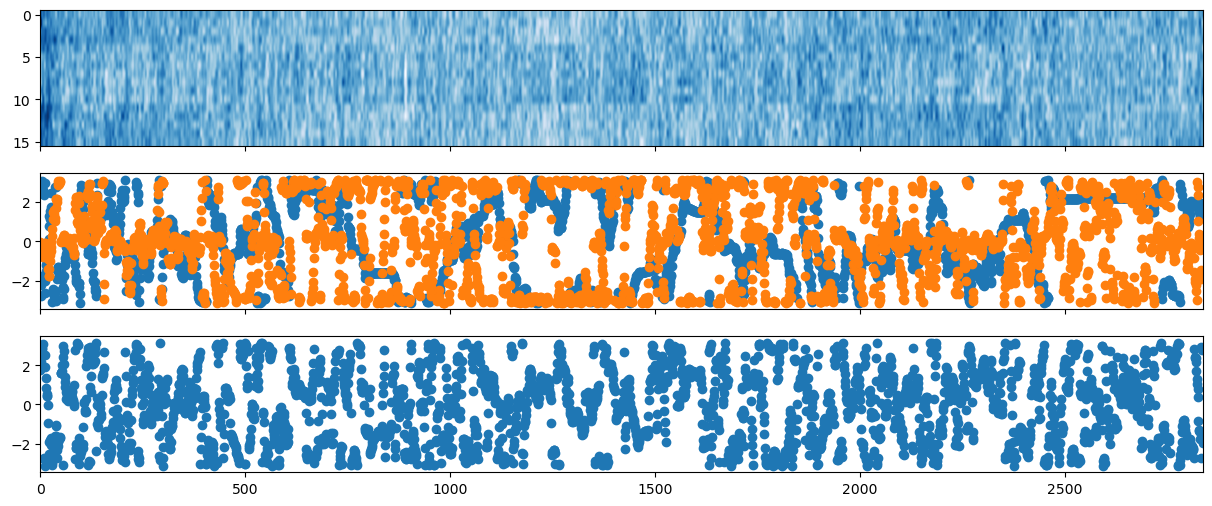

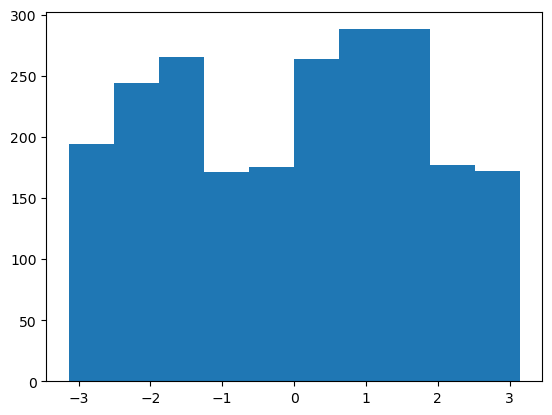

In [14]:
fig, ax= plt.subplots(3,1, figsize=[15,6], sharex=True)
ax[0].imshow(y_sm[0,:,:], aspect='auto', cmap= 'Blues', vmin=-2, vmax=2)
# ax.scatter(np.arange(y.shape[-1]), 15*(phi+np.pi)/2/np.pi)

print(pp.voltage_recording_aligned.columns)
# fig, ax= plt.subplots()

x = np.arange(y.shape[-1])
print(y.shape, heading.shape)
ax[1].scatter(x,heading)
ax[1].scatter(x, np.roll(phi,timelag))
ax[2].scatter(x, offset2)

mask = (heading>-3*np.pi/4) & (heading<3*np.pi/4)
fig, ax= plt.subplots()
ax.hist(offset2[mask])

In [15]:
mask.shape

(2836,)

(16,) (16,)


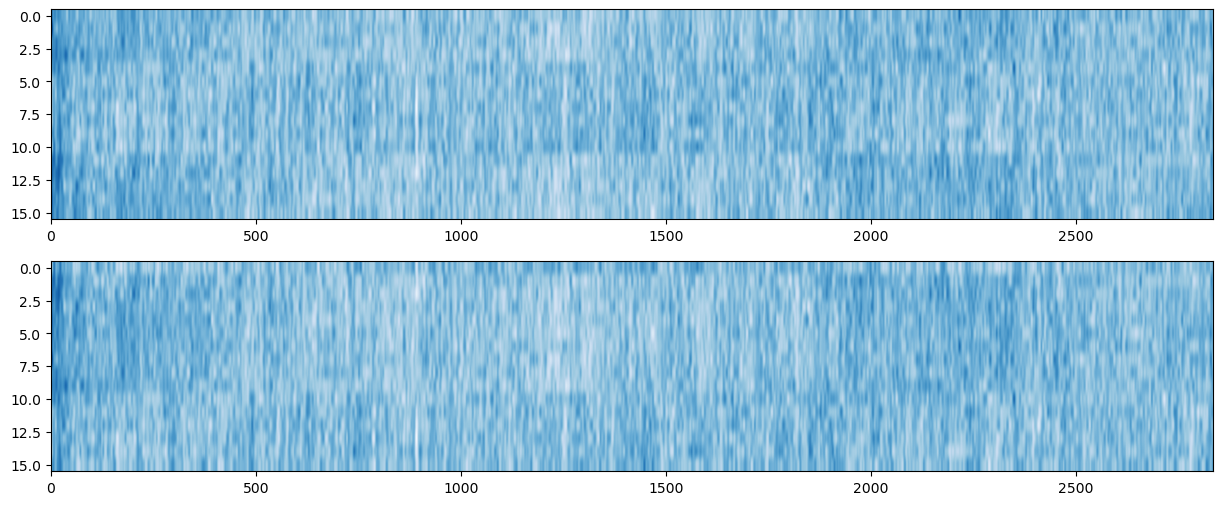

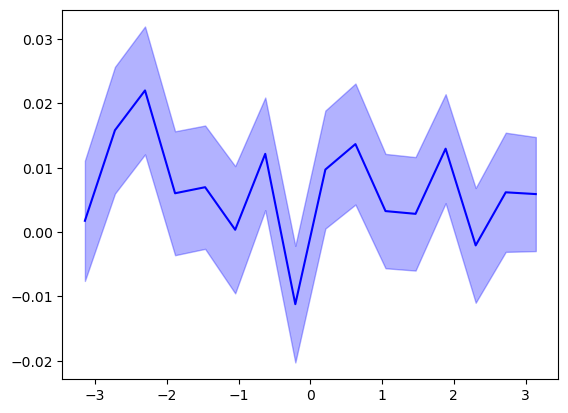

In [16]:
heading_ind = ((n_rois-1)*(heading+np.pi)/2/np.pi).astype(int)

y_sm_heading_aligned = np.roll(y_sm, heading_ind, axis=1)
# y_sm_heading_aligned = y_sm_heading_aligned/np.linalg.norm(y_sm_heading_aligned, axis=1)

fig, ax= plt.subplots(2,1, figsize=[15,6])
ax[0].imshow(y_sm[0,:, :], cmap='Blues',aspect='auto')
ax[1].imshow(y_sm_heading_aligned[0,:,:], cmap='Blues',aspect='auto')

# y_sm_ha = y
mu = y_sm_heading_aligned[:,:,mask].mean(axis=-1)[0,:]
sem = sp.stats.sem(y_sm_heading_aligned[:,:,mask], axis=-1)[0,:]
print(mu.shape, sem.shape)
fig, ax= plt.subplots()
ax.fill_between(np.linspace(-np.pi, np.pi, num=n_rois), mu-sem, mu+sem, alpha=.3, color='blue')
ax.plot(np.linspace(-np.pi, np.pi, num=n_rois), mu, color='blue')